관련 논문: https://pure.rug.nl/ws/files/127068391/1_s2.0_S0957417420301433_main.pdf

데이터셋: https://dataverse.nl/dataset.xhtml?persistentId=doi%3A10.34894%2FGKAQYN

## 데이터셋 요약 설명
총 행 수: 4681 (이더리움 계정 Address 정보)

총 열 수: 50개

목적: FLAG 컬럼을 통해 계정이 **정상(0)**인지 **악성(1)**인지를 분류


### 기본 정보
- `Index`: 고유 인덱스 번호
- `Address`: 이더리움 계정 주소
- `FLAG`: 이 계정이 정상(0)인지 악성(1)인지 나타냄 (라벨 컬럼)

### 일반 이더리움 트랜잭션 관련
- `Avg_min_between_sent_tnx`: 보낸 트랜잭션 사이의 평균 시간 간격 (분)
- `Avg_min_between_received_tnx`: 받은 트랜잭션 사이의 평균 시간 간격 (분)
- `Time_Diff_between_first_and_last_(Mins)`: 첫 번째와 마지막 트랜잭션 간의 시간 차 (분)
- `Sent_tnx`, `Received_Tnx`: 보낸/받은 트랜잭션 수
- `Number_of_Created_Contracts`: 해당 계정이 만든 스마트 컨트랙트 개수
- `Unique_Received_From_Addresses`, `Unique_Sent_To_Addresses`: 고유하게 받은/보낸 주소 수

### 트랜잭션 값 관련
- `min_value_received`, `max_value_received`, `avg_val_received`: 받은 트랜잭션의 최소/최대/평균값
- `min_val_sent`, `max_val_sent`, `avg_val_sent`: 보낸 트랜잭션의 최소/최대/평균값
- `min/max/avg_value_sent_to_contract`: 스마트 컨트랙트로 보낸 트랜잭션의 최소값/최대값/평균값

### 이더리움 송수신 관련
- `total_transactions_(including_tnx_to_create_contract)`: 총 트랜잭션 수 (스마트 컨트랙트를 만들기 위한 트랜잭션 포함)
- `total_Ether_sent`, `total_ether_received`: 총 이더 송수신량
- `total_ether_sent_contracts`: 스마트 컨트랙트로 보낸 총 이더량
- `total_ether_balance`: 최종 잔액

### ERC20 토큰 관련 통계

#### 거래량 관련
- `Total_ERC20_tnxs`: 총 ERC20 트랜잭션 수
- `ERC20_total_ether_sent`, `ERC20_total_Ether_received`: ERC20에서 보낸/받은 이더량
- `ERC20_total_Ether_sent_contract`: 스마트 컨트랙트로 전송된 ERC20 관련 이더리움 양

#### 유니크 주소 수 관련
- `ERC20_uniq_sent_addr`, `ERC20_uniq_rec_addr`: 고유하게 ERC20 토큰을 전송/수신한 주소 수
- `ERC20_uniq_sent_addr.1`: 논문에는 존재하지 않는 컬럼(중복된 컬럼으로 보임)
- `ERC20_uniq_rec_contract_addr`: 고유하게 ERC20 토큰을 받은 스마트 컨트랙트 주소 수

#### 시간 간격 관련
- `ERC20_avg_time_between_sent_tnx`, `ERC20_avg_time_between_rec_tnx`: ERC20 토큰 전송/수신 트랜잭션 간 평균 시간 간격
- `ERC20_avg_time_between_rec_2_tnx`: 첫 수신 이후 두 번째 수신까지의 평균 시간 간격
- `ERC20_avg_time_between_contract_tnx`: 스마트 컨트랙트와의 ERC20 거래 간 평균 시간 간격

#### 거래 값 관련 (ERC20 토큰 수치)
- `ERC20_min/max/avg_val_rec`: 수신된 ERC20 토큰 값 중 최소값/최대값/평균
- `ERC20_min/max/avg_val_sent`: 전송된 ERC20 토큰 값 중 최소값/최대값/평균
- `ERC20_min/max/avg_val_sent_contract`: 스마트 컨트랙트로 전송된 ERC20 토큰 중 최소값/최대값/평균

#### 토큰 이름/종류 관련
- `ERC20_uniq_sent_token_name`, `ERC20_uniq_rec_token_name`: 전송/수신한 고유 ERC20 토큰 이름 수
- `ERC20_most_sent_token_type`, `ERC20_most_rec_token_type`: 가장 많이 전송/수신된 ERC20 토큰 종류 (문자열)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE

import xgboost as xgb

import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random

In [33]:
df = pd.read_csv("/content/drive/MyDrive/안인/blockchain/Complete.csv")

df = df.drop(columns='Index') # 인덱스 제거
df = df.drop(columns='ERC20_uniq_sent_addr.1') # 중복된 컬럼

df['ERC20_most_sent_token_type'] = df['ERC20_most_sent_token_type'].astype('category')
df['ERC20_most_rec_token_type'] = df['ERC20_most_rec_token_type'].astype('category')
df

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,min_value_sent_to_contract,max_val_sent_to_contract,avg_value_sent_to_contract,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_sent_contracts,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_sent_tnx,ERC20_avg_time_between_rec_tnx,ERC20_avg_time_between_rec_2_tnx,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_min_val_sent_contract,ERC20_max_val_sent_contract,ERC20_avg_val_sent_contract,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
0,0x0020731604c882cf7bf8c444be97d17b19ea4316,1,1457.31,34.12,4815.43,3,13,0,10,3,1.000000,2.501052,1.348445,1.000875,11.277872,5.842916,0,0,0,16,17.528747,17.529785,0,0.001037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0x002bf459dc58584d58886169ea0e80f3ca95ffaf,1,3976.50,834.77,9622.53,2,2,0,1,2,0.586269,0.947515,0.766892,0.585408,0.947284,0.766346,0,0,0,4,1.532693,1.533785,0,0.001092,1.0,1.337000,0.0000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.337000,1.337000,1.337000,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
2,0x002f0c8119c16d310342d869ca8bf6ace34d9c39,1,112.90,31.87,321.42,2,3,0,3,1,0.001020,0.817800,0.439607,0.500390,0.817506,0.658948,0,0,0,5,1.317896,1.318820,0,0.000924,1.0,1.337000,0.0000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.337000,1.337000,1.337000,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
3,0x0059b14e35dab1b4eee1e2926c7a5660da66f747,1,2300.37,65.10,73091.00,29,98,0,89,26,0.000784,15.729068,0.383225,0.000000,36.700000,1.314957,0,0,0,127,38.133767,37.556046,0,-0.577721,96.0,142677.382900,120354.7684,0.0,6.0,55.0,37.0,0.0,0.0,0.0,0.0,0.000000,26436.081000,1954.484697,0.0,81324.0746,5232.816018,0.0,0.0,0.0,22.0,37.0,OCoin,OCoin
4,0x005b9f4516f8e640bbe48136901738b323c53b00,1,0.00,0.00,0.00,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4676,0xff010358a803a64a006b5b016e53814b631997d9,0,0.00,0.00,1.52,1,1,0,1,1,4.000000,4.000000,4.000000,3.999528,3.999528,3.999528,0,0,0,2,3.999528,4.000000,0,0.000472,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
4677,0xff2bdb6e32a93e6bb6fbab227fbdde07f721adae,0,9800.26,9384.37,489235.00,3,49,0,4,1,0.095005,10.200000,1.071227,2.130000,15.000000,6.910000,0,0,0,52,20.730000,52.490126,0,31.760126,12.0,2054.014084,0.0000,0.0,0.0,8.0,12.0,0.0,0.0,0.0,0.0,0.000000,1013.165787,171.167840,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,12.0,,VIU
4678,0xff45c8f8595288344b7dbe08f678d35cea34a5e0,0,0.00,0.00,173.97,1,1,0,1,1,0.700000,0.700000,0.700000,0.699580,0.699580,0.699580,0,0,0,2,0.699580,0.700000,0,0.000420,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,0,0
4679,0xff91e7d4eeb3b71d2b61ea8022b5f53155094aa0,0,7.72,502.02,1521.52,2,3,0,1,1,0.010000,5.000000,2.003333,1.008722,4.999291,3.004007,0,0,0,5,6.008013,6.010000,0,0.001987,0.0,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.0,0.0

## 기본 정보 확인

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4681 entries, 0 to 4680
Data columns (total 48 columns):
 #   Column                                                 Non-Null Count  Dtype   
---  ------                                                 --------------  -----   
 0   Address                                                4681 non-null   object  
 1   FLAG                                                   4681 non-null   int64   
 2   Avg_min_between_sent_tnx                               4681 non-null   float64 
 3   Avg_min_between_received_tnx                           4681 non-null   float64 
 4   Time_Diff_between_first_and_last_(Mins)                4681 non-null   float64 
 5   Sent_tnx                                               4681 non-null   int64   
 6   Received_Tnx                                           4681 non-null   int64   
 7   Number_of_Created_Contracts                            4681 non-null   int64   
 8   Unique_Received_From_Addresses        

### 데이터 통계 확인

In [35]:
# 데이터 통계 확인
pd.set_option('display.max_columns', None)
df.describe()

,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,min_value_sent_to_contract,max_val_sent_to_contract,avg_value_sent_to_contract,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_sent_contracts,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_sent_tnx,ERC20_avg_time_between_rec_tnx,ERC20_avg_time_between_rec_2_tnx,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_min_val_sent_contract,ERC20_max_val_sent_contract,ERC20_avg_val_sent_contract,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name
count,4681.000000,4681.000000,4681.000000,4.681000e+03,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.000000,4681.0,4681.0,4681.0,4681.000000,4.681000e+03,4.681000e+03,4681.0,4.681000e+03,3852.000000,3.852000e+03,3.852000e+03,3852.000000,3852.000000,3852.000000,3852.000000,3852.0,3852.0,3852.0,3852.0,3852.000000,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3.852000e+03,3852.0,3852.0,3852.0,3852.000000,3852.000000
mean,0.465499,3433.476676,5175.318889,1.310965e+05,92.834651,189.607990,4.955992,42.812647,25.743004,49.220707,862.718485,134.960150,7.265699,551.763248,39.239685,0.0,0.0,0.0,287.398633,9.620500e+03,1.176427e+04,0.0,2.143766e+03,22.639148,2.826489e+08,3.001831e+07,254.235579,2.639408,5.912513,4.615524,0.0,0.0,0.0,0.0,722.419947,2.765535e+08,7.806912e+06,2.852135e+04,2.974736e+07,1.474142e+07,0.0,0.0,0.0,1.249221,4.550883
std,0.498862,16386.028874,18295.726331,2.396813e+05,734.368423,1141.163981,185.494671,355.514463,248.704643,461.804628,18076.094130,4178.365245,191.153317,12897.272173,292.944498,0.0,0.0,0.0,1491.697870,2.763359e+05,2.751030e+05,0.0,3.594646e+05,260.473628,1.611767e+10,1.804668e+09,9364.979824,41.091351,42.678667,16.855085,0.0,0.0,0.0,0.0,19979.431933,1.611679e+10,3.256581e+08,1.614944e+06,1.804656e+09,9.046988e+08,0.0,0.0,0.0,6.293496,16.421821
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.0,-1.560535e+07,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,6.965000e+01,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.510000,0.269876,0.000000,0.000000,0.000000,0.0,0.0,0.0,3.000000,0.000000e+00,1.000000e+00,0.0,4.410000e-04,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,3.340000,92.650000,1.073972e+04,2.000000,3.000000,0.000000,2.000000,1.000000,0.044000,4.000000,1.063480,0.051701,2.822265,1.237457,0.0,0.0,0.0,6.000000,4.473939e+00,1.694038e+01,0.0,1.554000e-03,1.000000,1.337000e+00,0.000000e+00,0.000000,0.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,1.337000e+00,8.089090e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,1.000000,164.890000,2284.990000,1.835153e+05,4.000000,18.000000,0.000000,6.000000,3.000000,1.000000,52.039698,13.193118,1.335323,49.989560,17.879319,0.0,0.0,0.0,27.000000,1.009984e+02,1.010000e+02,0.0,1.344000e-02,2.000000,1.337000e+01,0.000000e+00,0.000000,0.000000,2.000000,2.000000,0.0,0.0,0.0,0.0,1.337000,1.337000e+01,1.337000e+01,0.000000e+00,0.00000

min_value_sent_to_contract, max_val_sent_to_contract, avg_value_sent_to_contract,

total_ether_sent_contracts,  

ERC20_avg_time_between_sent_tnx, ERC20_avg_time_between_rec_tnx, ERC20_avg_time_between_rec_2_tnx, ERC20_avg_time_between_contract_tnx

ERC20_min_val_sent_contract, ERC20_max_val_sent_contract, ERC20_avg_val_sent_contract

-> 데이터의 통계를 확인하였을 때, 해당 컬럼은 모든 값이 0으로 이루어짐

-> 모델의 훈련에 필요없을 듯 하다

In [36]:
# 값이 모두 0으로 이루어진 컬럼들
col_zero = ["min_value_sent_to_contract", "max_val_sent_to_contract","avg_value_sent_to_contract", "total_ether_sent_contracts",
           "ERC20_avg_time_between_sent_tnx", "ERC20_avg_time_between_rec_tnx", "ERC20_avg_time_between_rec_2_tnx", "ERC20_avg_time_between_contract_tnx",
           "ERC20_min_val_sent_contract", "ERC20_max_val_sent_contract", "ERC20_avg_val_sent_contract"]

### 데이터 불균형 확인

In [37]:
# 데이터 불균형 확인
df['FLAG'].value_counts()

,count
FLAG,
0,2502
1,2179


- 0과 1의 값이 균형있게 존재해, 데이터 불균형을 해결하기 위한 추가적인 조치는  필요없을 거 같다.

### 범주형 변수 확인

In [38]:
df['ERC20_most_sent_token_type'].value_counts()

,count
ERC20_most_sent_token_type,
,1794
0,1544
blockwell.ai KYC Casper Token,65
OmiseGO,47
EOS,40
...,...
Wrapped Ether,1
eosDAC Community Owned EOS Block Producer ERC20 Tokens,1
district0x,1


In [39]:
df['ERC20_most_rec_token_type'].value_counts()

,count
ERC20_most_rec_token_type,
0,1544
Blockwell say NOTSAFU,779
OmiseGO,355
VIU,81
GSENetwork,80
...,...
WAX Token,1
savedroid,1
empowr,1


- 4681개의 행 중 1000~2000 개의 행들의 토큰값이 0으로 나타나 있다.
- 또한, 토큰 값의 종류가 대략 200개 이상으로 다양하게 분배되어 있다.
- 이러한 이유로 라벨인코딩이나 원핫인코딩 등의 방법을 사용하여 mlp 모델의 훈련에 사용하는 방식은 적합하지 않아 보인다.

## 중복된 주소 행 제거

In [40]:
# 중복된 주소
add_count = df['Address'].value_counts()
dup= add_count[add_count == 2]
dup = dup.index.tolist()
dup

['0x75e7f640bf6968b6f32c47a3cd82c3c2c9dcae68',
 '0x8271b2e8cbe29396e9563229030c89679b9470db',
 '0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c',
 '0x96fc4553a00c117c5b0bed950dd625d1c16dc894',
 '0x91337a300e0361bddb2e377dd4e88ccb7796663d']

In [41]:
df[df['Address'].isin(dup)]

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,min_value_sent_to_contract,max_val_sent_to_contract,avg_value_sent_to_contract,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_sent_contracts,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_sent_tnx,ERC20_avg_time_between_rec_tnx,ERC20_avg_time_between_rec_2_tnx,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_min_val_sent_contract,ERC20_max_val_sent_contract,ERC20_avg_val_sent_contract,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
2178,0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c,1,37242.70,149.56,670817.33,18,3,0,1,5,0.795233,18998.00000,6333.265078,0.900,1000.000000,644.427778,0,0,0,21,11599.70000,18999.79523,0,7400.095233,44.0,6.007075e+04,0.000000e+00,0.0,0.0,37.0,42.0,0.0,0.0,0.0,0.0,0.0,2.018061e+04,1.365244e+03,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,42.0,,INS Promo1
2755,0x75e7f640bf6968b6f32c47a3cd82c3c2c9dcae68,0,5.43,5.01,51182.03,2575,7425,0,1100,1648,0.000025,20000.00000,13.182674,0.000,23519.828880,36.648675,0,0,0,10000,94370.33921,97881.35701,0,3511.017805,412.0,7.371090e+07,1.435403e+05,0.0,46.0,177.0,208.0,0.0,0.0,0.0,0.0,0.0,6.908782e+07,2.161610e+05,0.000000,2.257947e+04,2.021695e+03,0.0,0.0,0.0,30.0,200.0,OmiseGO,KickCoin
2834,0x8271b2e8cbe29396e9563229030c89679b9470db,0,31.85,30.79,312377.08,4215,5785,0,2526,2485,0.099380,3499.99958,18.169959,0.000,5000.000000,23.666126,0,0,0,10000,99752.72101,105113.21040,0,5360.489412,117.0,1.832988e+09,2.778053e+08,0.0,4.0,81.0,94.0,0.0,0.0,0.0,0.0,0.0,1.553031e+09,1.651341e+07,0.133261,2.770000e+08,4.630089e+07,0.0,0.0,0.0,4.0,94.0,CANDY,Reputation
2894,0x91337a300e0361bddb2e377dd4e88ccb7796663d,0,5.35,2.21,23838.73,554,9446,0,1088,341,0.000386,14214.06958,21.737908,0.010,9999.990000,202.649242,0,0,0,10000,112267.68000,205336.27930,0,93068.599230,54.0,1.308262e+05,8.880000e+02,0.0,1.0,39.0,43.0,0.0,0.0,0.0,0.0,0.0,3.424015e+04,2.468419e+03,888.000000,8.880000e+02,8.880000e+02,0.0,0.0,0.0,1.0,40.0,tq2342.mjbsc.com Online casino,SONM
2924,0x96fc4553a00c117c5b0bed950dd625d1c16dc894,0,24.30,28.26,257374.55,6362,3638,0,2257,2088,0.000012,1489.94000,14.616320,0.002,1758.263098,8.170409,0,0,0,10000,51980.14237,53174.17165,0,1194.029282,97.0,5.566450e+05,7.658749e+03,0.0,6.0,72.0,80.0,0.0,0.0,0.0,0.0,0.0,4.505231e+05,6.184944e+03,0.052769,6.239900e+03,1.094107e+03,0.0,0.0,0.0,4.0,76.0,Ether,PowerLedger
3220,0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c,0,37242.70,149.56,670817.33,18,3,0,1,5,0.795233,18998.00000,6333.265078,0.900,1000.000000,644.427778,0,0,0,21,11599.70000,18999.79523,0,7400.095233,44.0,6.007075e+04,0.000000e+00,0.0,0.0,37.0,42.0,0.0,0.0,0.0,0.0,0.0,2.018061e+04,1.365244e+03,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,42.0,,Super Wallet Token
3995,0x75e7f640bf6968b6f32c47a3cd82c3c2c9dcae68,0,5.43,5.01,51182.03,2575,7425,0,1100,1648,0.000025,20000.00000,13.182674,0.000,23519.828880,36.648675,0,0,0,10000,94370.33921,97881.35701,0,3511.017805,412.0,7.371090e+07,1.435403e+05,0.0,46.0,177.0,208.0,0.0,0.0,0.0,0.0,0.0,6.908782e+07,2.161610e+05,0.000000,2.257947e+04,2.021695e+03,0.0,0.0,0.0,30.0,200.0,OmiseGO,KickCoin
4052,0x8271b2e8cbe29396e9563229030c89679b9470db,0,31.85,30.79,312377.08,4215,5785,0,2526,2485,0.099380,3499.99958,18.169959,0.000,5000.000000,23.666126,0,0,0,10000,99752.72101,105113.21040,0,5360.489412,117.0,1.832988e+09,2.778053e+08,0.0,4.0,81.0,94.0,0.0,0.0,0.

In [42]:
print(df.loc[2178].equals(df.loc[3220])) # 0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c
print(df.loc[2755].equals(df.loc[3995])) # 0x75e7f640bf6968b6f32c47a3cd82c3c2c9dcae68
print(df.loc[2834].equals(df.loc[4052])) # 0x8271b2e8cbe29396e9563229030c89679b9470db
print(df.loc[2894].equals(df.loc[4118])) # 0x91337a300e0361bddb2e377dd4e88ccb7796663d
print(df.loc[2924].equals(df.loc[4144])) # 0x96fc4553a00c117c5b0bed950dd625d1c16dc894

False
True
True
True
True


In [43]:
pd.set_option('display.max_columns', None)
df[df['Address']=='0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c']

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,min_value_sent_to_contract,max_val_sent_to_contract,avg_value_sent_to_contract,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_sent_contracts,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_sent_tnx,ERC20_avg_time_between_rec_tnx,ERC20_avg_time_between_rec_2_tnx,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_min_val_sent_contract,ERC20_max_val_sent_contract,ERC20_avg_val_sent_contract,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
2178,0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c,1,37242.7,149.56,670817.33,18,3,0,1,5,0.795233,18998.0,6333.265078,0.9,1000.0,644.427778,0,0,0,21,11599.7,18999.79523,0,7400.095233,44.0,60070.75179,0.0,0.0,0.0,37.0,42.0,0.0,0.0,0.0,0.0,0.0,20180.614,1365.244359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,,INS Promo1
3220,0xd624d046edbdef805c5e4140dce5fb5ec1b39a3c,0,37242.7,149.56,670817.33,18,3,0,1,5,0.795233,18998.0,6333.265078,0.9,1000.0,644.427778,0,0,0,21,11599.7,18999.79523,0,7400.095233,44.0,60070.75179,0.0,0.0,0.0,37.0,42.0,0.0,0.0,0.0,0.0,0.0,20180.614,1365.244359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,,Super Wallet Token



```
0x75e7f~, 0x8271b~, 0x91337~, 0x96fc4~
```
- 해당 주소들이 중복되어 나타는 행들의 데이터를 살펴보면 모두 일치함
- 똑같은 행 2개 중 하나의 행을 제거

```
0xd624d~
```
- 해당 주소가 중복되어 나타나는 행의 데이터를 보면, FLAG 값과 tocken type 값이 다름
- tocken type은 mlp 모델을 훈련하는데 사용되지 않는 변수. 그런데 tocken type 외의 피쳐는 모두 같은데, FLAG가 다르므로 이는 모델의 예측에 방해가 될 수 있으므로 해당 주소의 데이터 모두 제거


In [44]:
# 중복 Address 중 하나만 남기고 제거
df = df.drop([2178, 3220, 2755, 2834, 2894, 2924])
df.value_counts('Address')

,count
Address,
0xfffdfc3513b990a30ef0b4bead4886c4c7cd2bec,1
0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,1
0x0002b44ddb1476db43c868bd494422ee4c136fed,1
0xff14d2d311b183eaa201a5ff15da9d7222048379,1
0xff0e20e3a7575d823302bbb27e233c23f2c3070b,1
...,...
0x00235134f8335d48cf506b25cc376fc84520588b,1
0x0020731604c882cf7bf8c444be97d17b19ea4316,1
0x001f99982965a3792077893ecadc7be0c61d613c,1


## 결측치 탐색

In [45]:
df.isnull().sum()

,0
Address,0
FLAG,0
Avg_min_between_sent_tnx,0
Avg_min_between_received_tnx,0
Time_Diff_between_first_and_last_(Mins),0
Sent_tnx,0
Received_Tnx,0
Number_of_Created_Contracts,0
Unique_Received_From_Addresses,0
Unique_Sent_To_Addresses,0


- ERC20 관련 컬럼들은 모두 결측치가 존재
- ERC20 토큰 타입 관련 피처를 제외하고는 결측치의 개수가 모두 829개로 동일

In [46]:
# 결측치 하나라도 존재하는 데이터 출력
null_check = df[df.isnull().any(axis=1)]
null_check['FLAG'].value_counts()

,count
FLAG,
1,829
0,8


- 결측치가 존재하는 데이터 중, 사기가 아닌 것은 오직 8개

In [47]:
null_check.tail(10)

,Address,FLAG,Avg_min_between_sent_tnx,Avg_min_between_received_tnx,Time_Diff_between_first_and_last_(Mins),Sent_tnx,Received_Tnx,Number_of_Created_Contracts,Unique_Received_From_Addresses,Unique_Sent_To_Addresses,min_value_received,max_value_received,avg_val_received,min_val_sent,max_val_sent,avg_val_sent,min_value_sent_to_contract,max_val_sent_to_contract,avg_value_sent_to_contract,total_transactions_(including_tnx_to_create_contract),total_Ether_sent,total_ether_received,total_ether_sent_contracts,total_ether_balance,Total_ERC20_tnxs,ERC20_total_Ether_received,ERC20_total_ether_sent,ERC20_total_Ether_sent_contract,ERC20_uniq_sent_addr,ERC20_uniq_rec_addr,ERC20_uniq_rec_contract_addr,ERC20_avg_time_between_sent_tnx,ERC20_avg_time_between_rec_tnx,ERC20_avg_time_between_rec_2_tnx,ERC20_avg_time_between_contract_tnx,ERC20_min_val_rec,ERC20_max_val_rec,ERC20_avg_val_rec,ERC20_min_val_sent,ERC20_max_val_sent,ERC20_avg_val_sent,ERC20_min_val_sent_contract,ERC20_max_val_sent_contract,ERC20_avg_val_sent_contract,ERC20_uniq_sent_token_name,ERC20_uniq_rec_token_name,ERC20_most_sent_token_type,ERC20_most_rec_token_type
2173,0xff35866acb80ce4b169d1460cd48108955c1c445,1,0.00,0.00,8427.92,0,1,1,1,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,2,0.000000,0.000000,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2177,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,1,0,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,0,0,0,1,0.000000,0.500000,0,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2340,0x1e9939daaad6924ad004c2560e90804164900341,0,5.06,1768.96,54128.18,9998,2,0,2,211,2.000000,100.000000,51.000000,0.095013,14.971483,2.596055,0,0,0,10000,25955.357420,102.000000,0,-25853.357420,7.0,6.241702e+02,319.117725,0.0,1.0,6.0,6.0,0.0,0.0,0.0,0.0,0.0000,3.191177e+02,104.028371,319.117725,319.117725,319.117725,0.0,0.0,0.0,1.0,6.0,OmiseGO,NaN
3169,0xcb00beab3d8f3c719aada83ec42d8bcac917afec,0,29.48,15.75,203493.85,3351,6649,0,2372,1741,0.008212,102.662080,0.731565,0.000000,108.035516,1.449984,0,0,0,10000,4858.896368,4864.173899,0,5.277531,21.0,1.917217e+06,0.096221,0.0,1.0,14.0,20.0,0.0,0.0,0.0,0.0,0.0000,1.913453e+06,95860.862900,0.096221,0.096221,0.096221,0.0,0.0,0.0,1.0,20.0,Ether,NaN
3687,0x35ea42f703b3b87b400833bd5d425810392ac7fc,0,24.22,756.38,1519411.20,1274,1968,0,12,3,0.000000,14.990000,0.658793,0.483114,14.989370,1.016609,0,0,0,3242,1295.159796,1296.504495,0,1.344699,10.0,4.763495e+02,0.000000,0.0,0.0,8.0,10.0,0.0,0.0,0.0,0.0,0.0000,3.650000e+02,47.634950,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,10.0,,NaN
4165,0x9c67e141c0472115aa1b98bd0088418be68fd249,0,32.07,5.23,85729.47,1247,8753,0,1554,721,0.000025,1000.000000,1.205974,0.000005,557.999000,7.974060,0,0,0,10000,9943.652855,10555.892690,0,612.239830,20.0,1.004133e+06,244.217430,0.0,1.0,18.0,19.0,0.0,0.0,0.0,0.0,0.0000,1.000000e+06,52849.110250,244.217430,244.217430,244.217430,0.0,0.0,0.0,1.0,19.0,OmiseGO,NaN
4246,0xace62f87abe9f4ee9fd6e115d91548df24ca0943,0,0.00,3.82,38229.32,0,9999,1,6290,0,0.000000,2000.000000,6.286646,0.000000,0.000000,0.000000,0,0,0,10000,0.000000,62860.169070,0,62860.169070,3.0,1.619795e+01,0.000000,0.0,0.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0001,1.530896e+01,5.399316,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,3.0,,NaN
4308,0xb74bfccc39f2a0c75e0fa2e3cb9b3c5086d2133c,0,13502.42,280954.10,804951.82,18,2,0,2,8,0.012220,20.000000,10.006110,0.000000,10.000000,2.221363,0,0,0,20,39.984526,20.012220,0,-19.972306,7.0,3.596788e+02,19.992030,0.0,2.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0000,3.193111e+02,71.935761,3.332005,16.660025,9.996015,0.0,0.0,0.0,2.0,5.0,NaN,VIU
4356,0xc026b9aad41d6cea0abce6fb3854645ded45e268,0,13726.03,39025.39,749283.42,29,9,0,3,24,0.015000,5.214770,1.616576,0.000000,5.214000,0.500788,0,0,0,38,14.522862,14.549182,0,0.026320,59.0,3.059739e+05,20090.000000,0.0,2.0,40.0,53.0,0.0,0.0,0.0,0.0,0.0000,1.187991e+05,5563.16190

In [48]:
null_check.tail(8).isnull().sum()

,0
Address,0
FLAG,0
Avg_min_between_sent_tnx,0
Avg_min_between_received_tnx,0
Time_Diff_between_first_and_last_(Mins),0
Sent_tnx,0
Received_Tnx,0
Number_of_Created_Contracts,0
Unique_Received_From_Addresses,0
Unique_Sent_To_Addresses,0


In [49]:
null_check.shape

(837, 48)

In [50]:
null_check['FLAG'].value_counts()

,count
FLAG,
1,829
0,8


**결론**
- 결측치가 존재하는 행은 총 837개
- 그 중에서 829개는 ERC20 관련 컬럼에서 모두 결측치가 존재하며, 사기계정이다
- 그 중에서 8개는 ERC20 tocken type 관련 컬럼에서만 결측치가 존재하며, 사기계정이 아니다.

## 시각화

In [64]:
num_df = df.select_dtypes(include=['int64', 'float64'])
num_col = num_df.columns.tolist()

### 상관관계

Text(0.5, 0, '상관계수 (절대값)')

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 45458 (\N{HANGUL SYLLABLE NOP}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 51008 (\N{HANGUL SYLLABLE EUN}) m

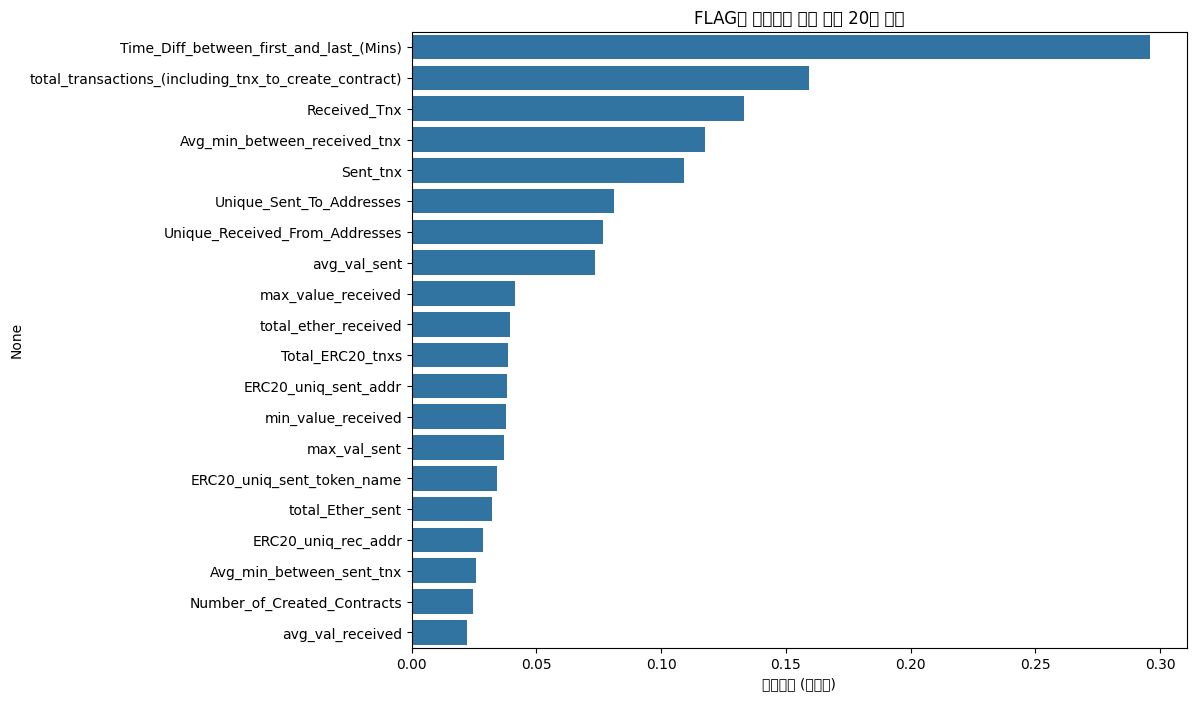

In [65]:
# FLAG와 상관관계 추출
corr_flag = num_df.corr()["FLAG"].drop("FLAG").abs().sort_values(ascending=False)

# 상위 20개 시각화
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_flag.head(20), y=corr_flag.head(20).index)
plt.title("FLAG와 상관관계 높은 상위 20개 피처")
plt.xlabel("상관계수 (절대값)")

**FLAG와의 상관관계가 높은 상위 5개 컬럼**
1. Time_Diff_between_first_and_last_(Mins)
2. total_transactions_(including_tnx_to_create_contract)
3. Received_Tnx
4. Avg_min_between_received_tnx
5. Sent_tnx

<Axes: >

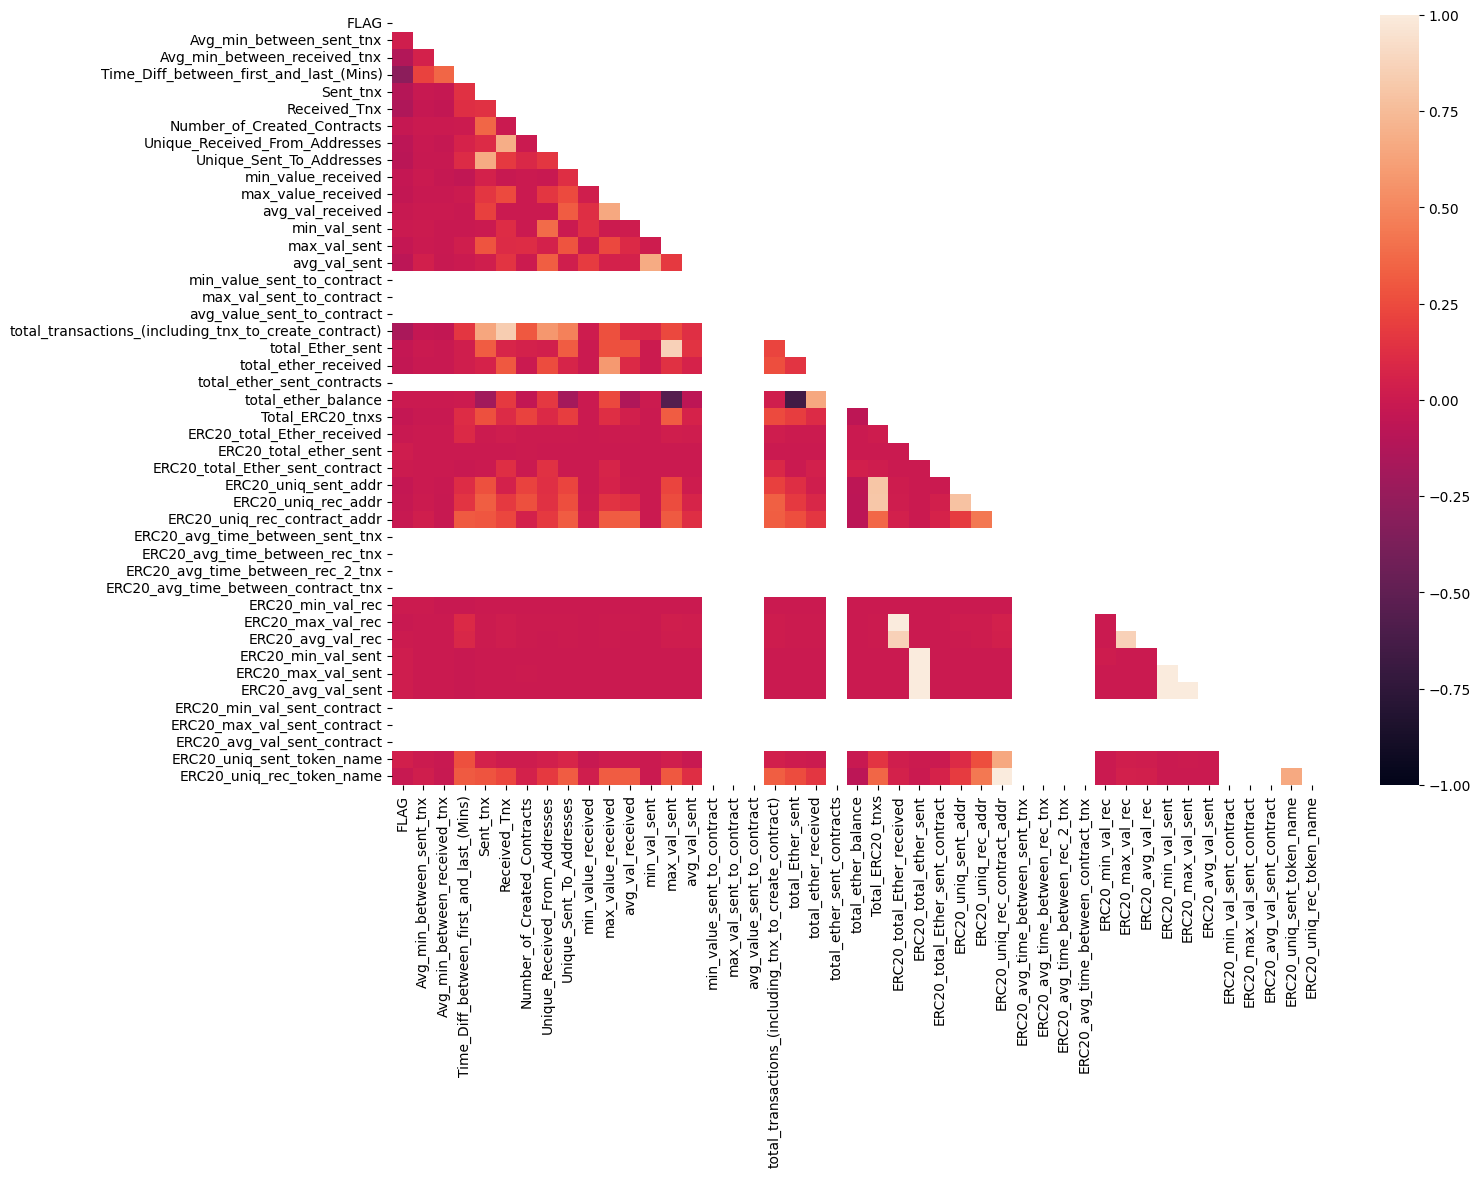

In [ ]:
# 히트맵
corr = num_df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
plt.figure(figsize=(15, 10))
sns.heatmap(corr, mask=mask, vmin=-1, vmax=1)

- 하얀색 부분은 데이터가 모두 0으로 이루어진 컬럼들

### histplot

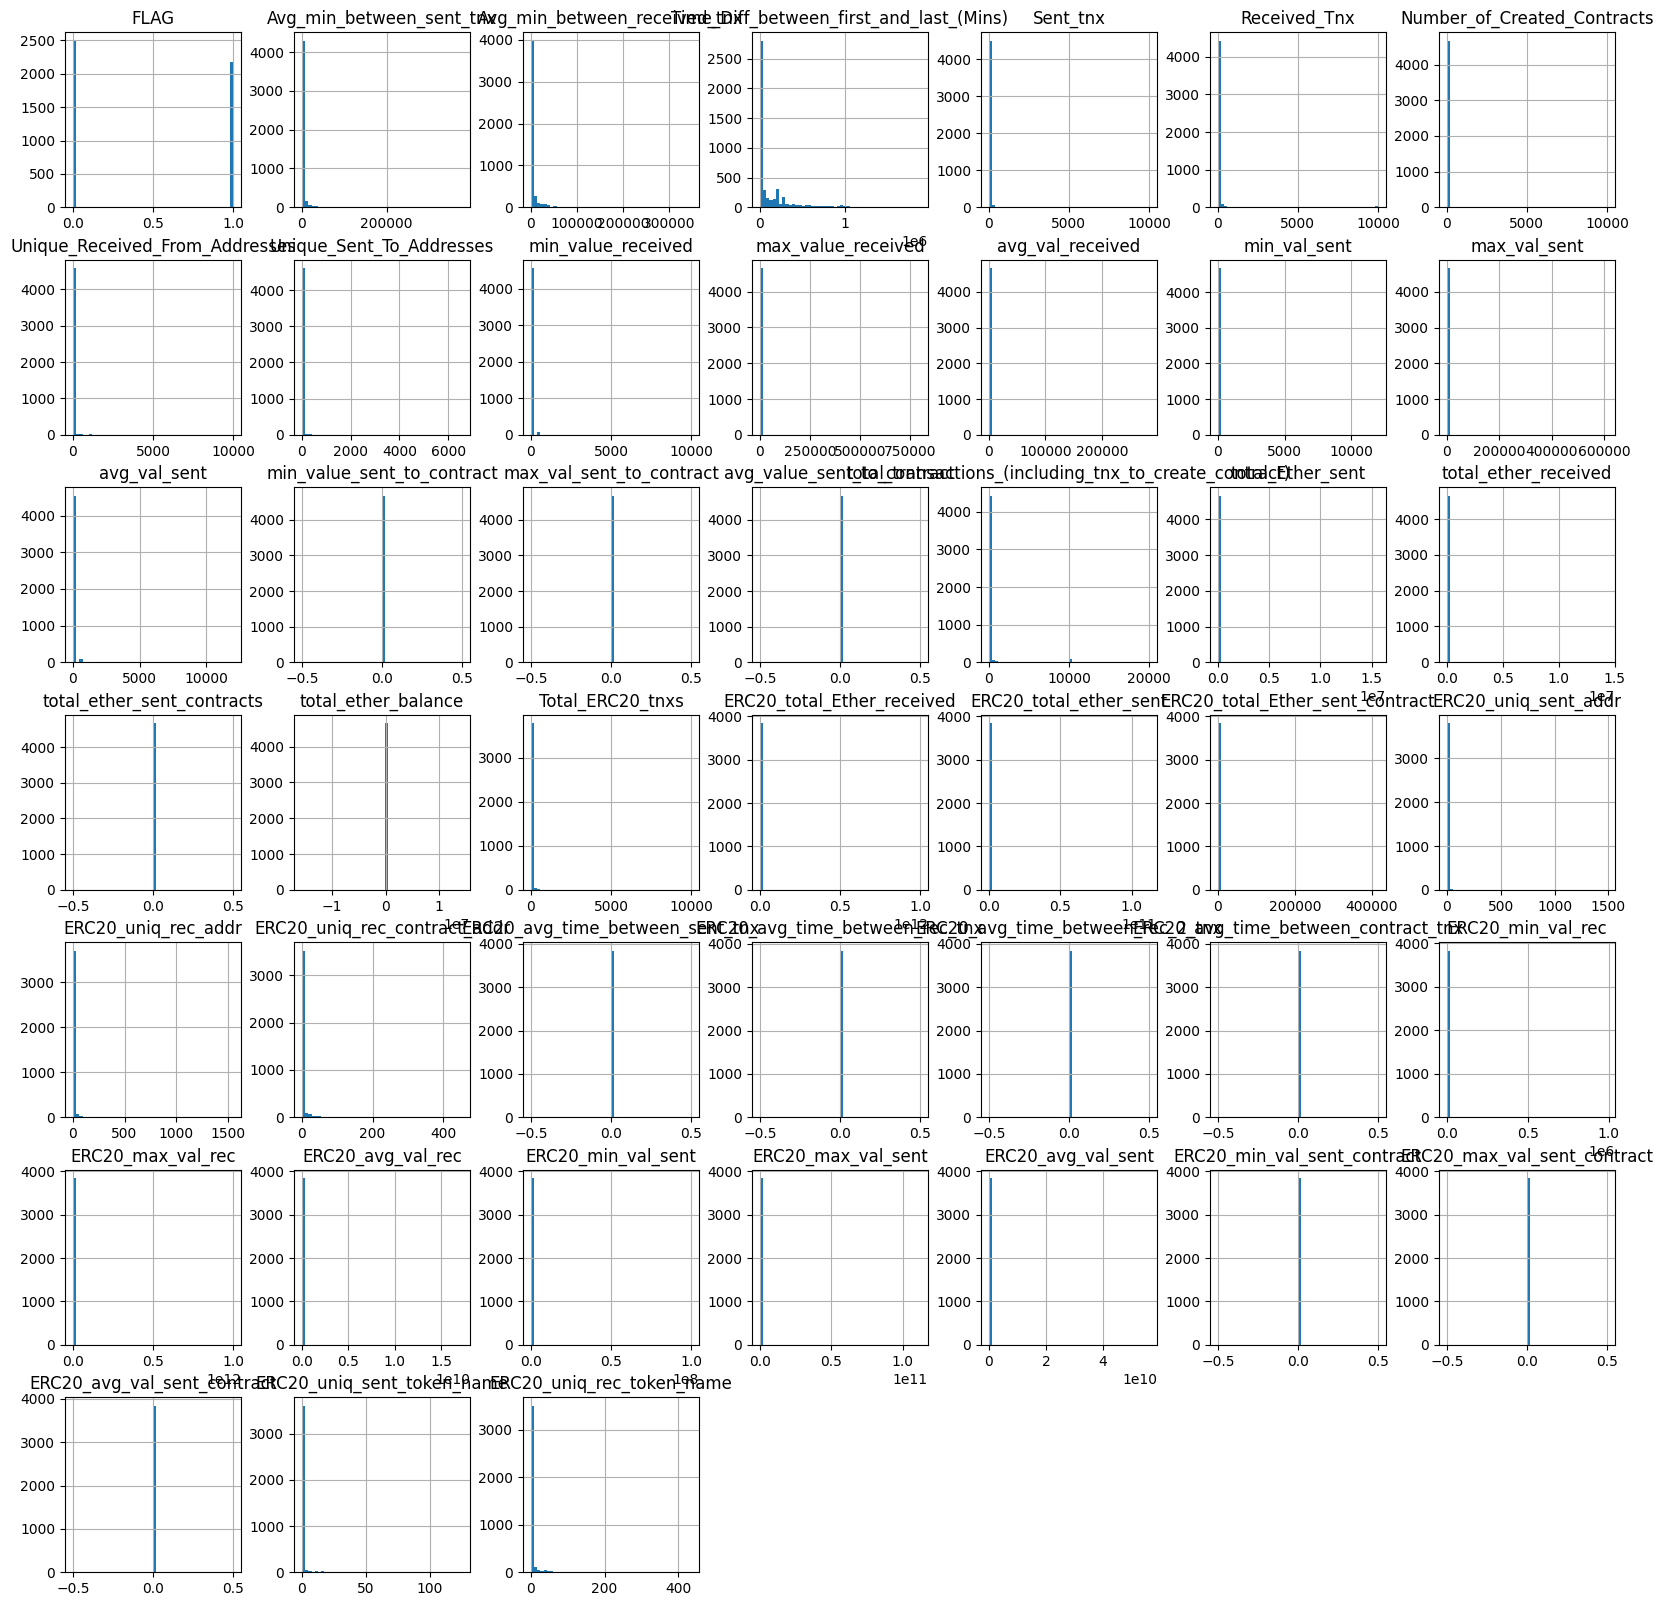

In [ ]:
h = num_df.hist(figsize=(20, 20), bins=50)

- 전반적으로 컬럼들의 데이터값이 0에 아주 많이 몰려있음

### boxplot

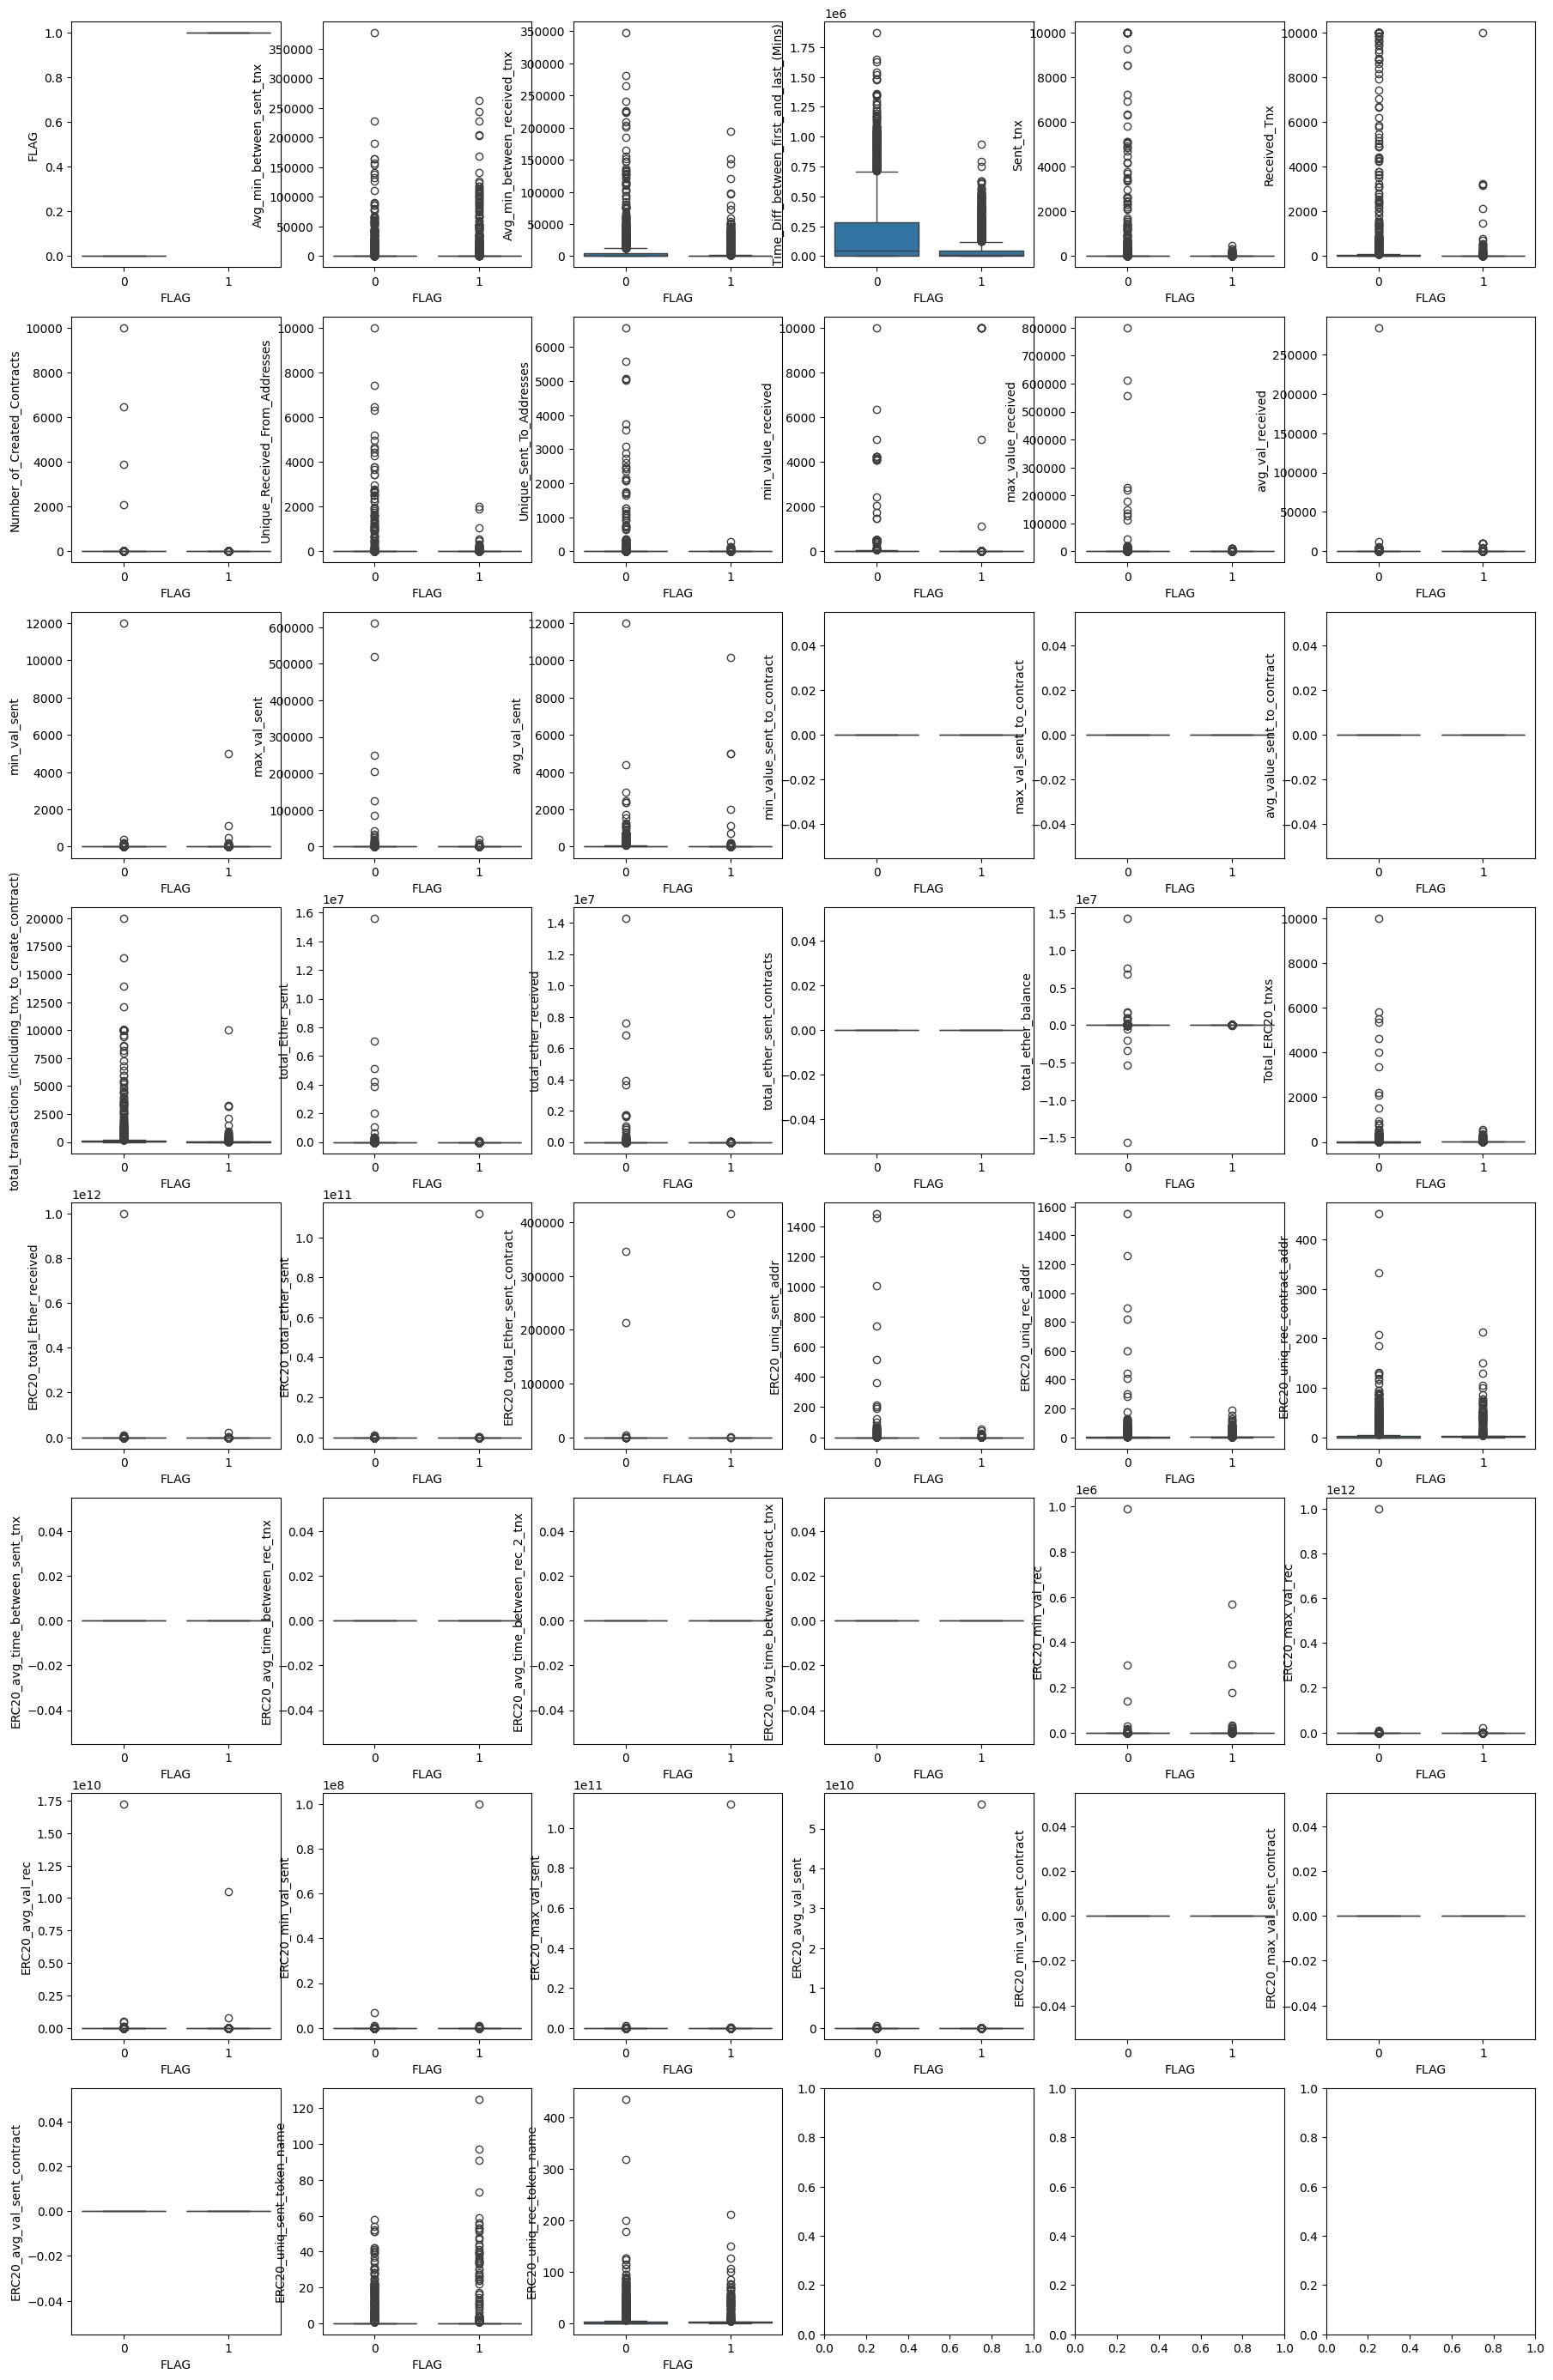

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(22, 35))

for i, col_name in enumerate(num_col):
  row=i//6
  col=i%6
  sns.boxplot(data=df, y=col_name, x="FLAG", ax=axes[row][col])

### scatterplot

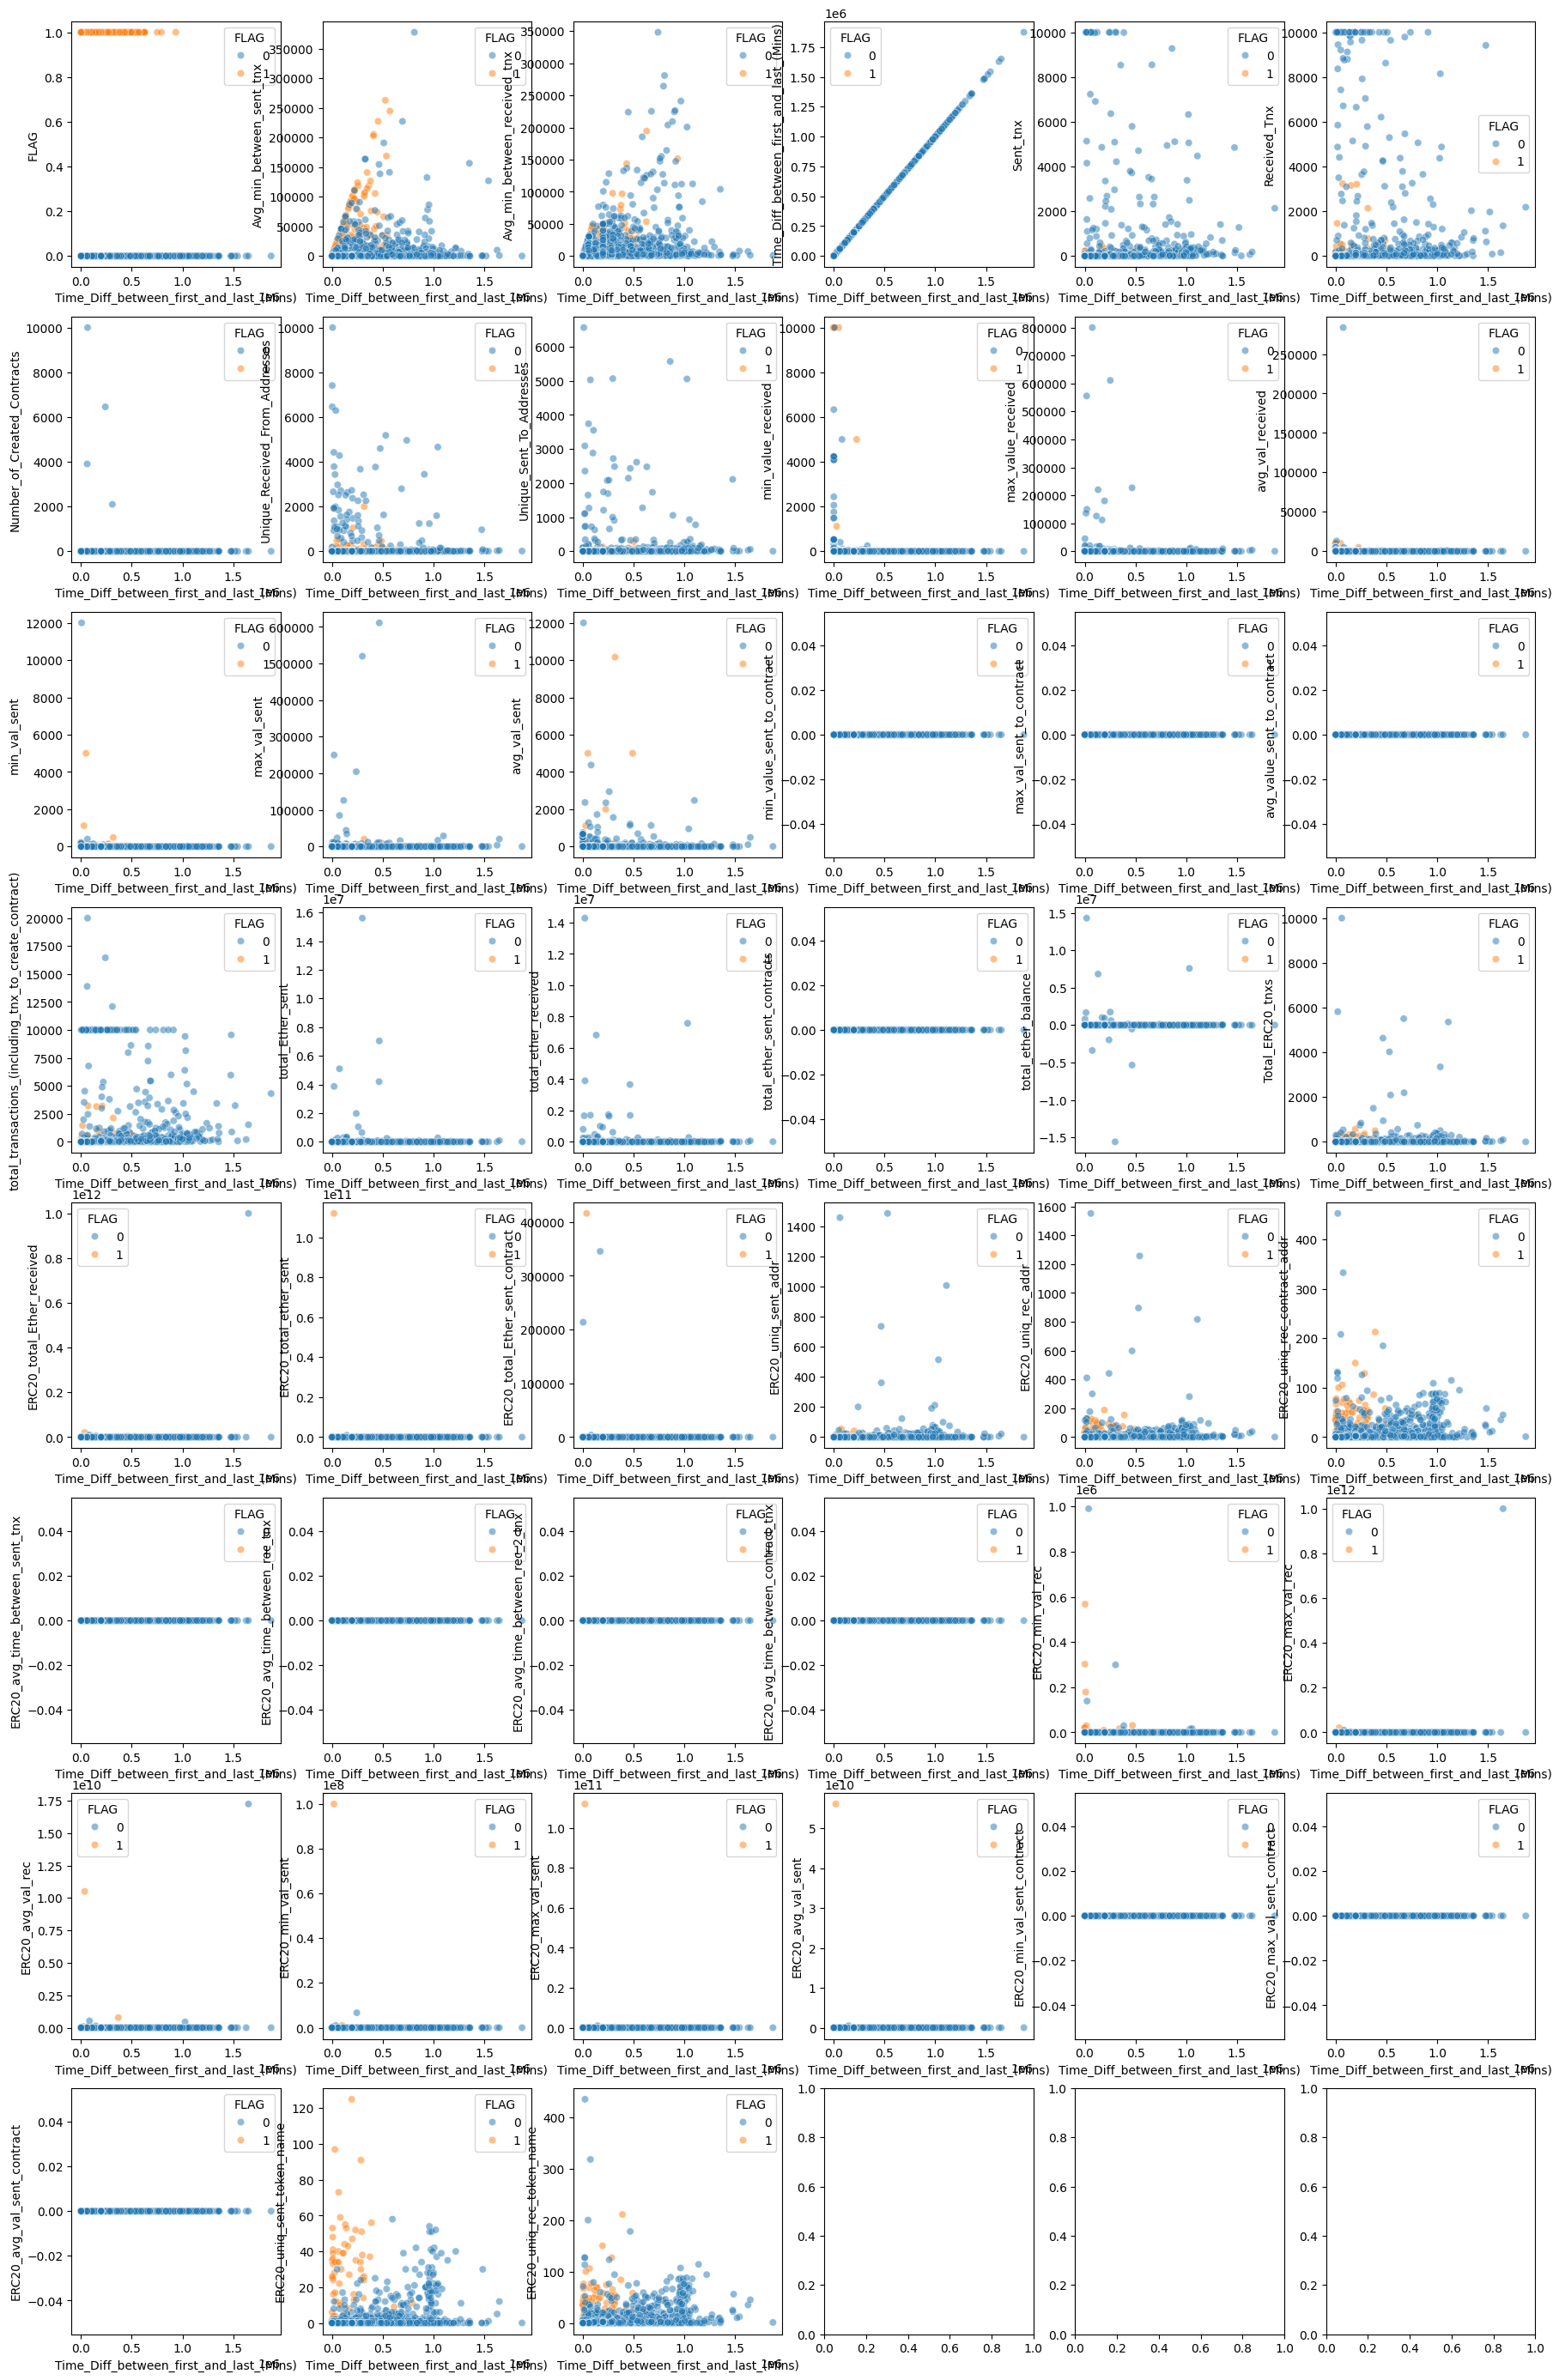

In [ ]:
fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(22, 35))

for i, col_name in enumerate(num_col):
  row=i//6
  col=i%6
  sns.scatterplot(data=df, y=col_name, x="Time_Diff_between_first_and_last_(Mins)", hue='FLAG', ax=axes[row][col], alpha=0.5)

### 차원축소 그래프

<Axes: title={'center': '"Anomaly Distribution (2D t-SNE)"'}, xlabel='Dim1', ylabel='Dim2'>

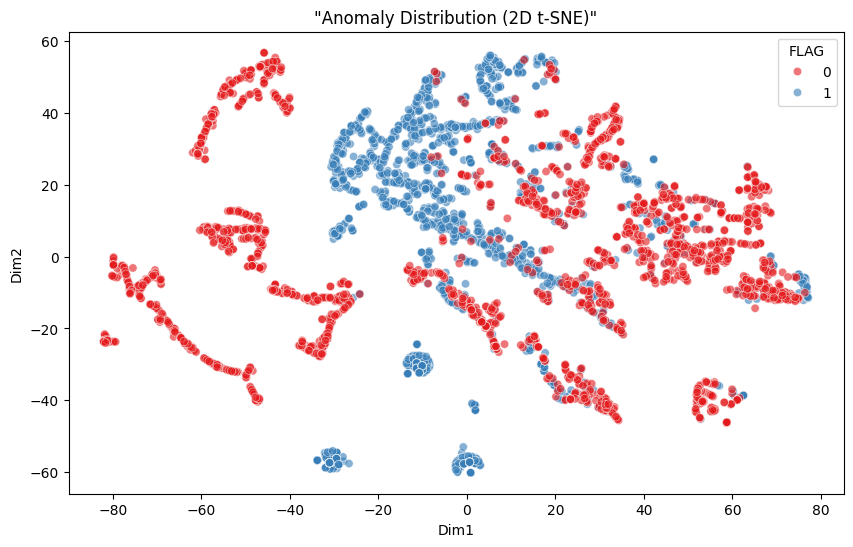

In [ ]:
df2 = df.copy()
df2 = df2.drop(columns=['Address', 'ERC20_most_sent_token_type', 'ERC20_most_rec_token_type'])

# 결측치 처리
df2 = df2.fillna(df2.median())

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df2.drop(columns=['FLAG']))
y = df2['FLAG']

# 차원축소 - 2차원
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# 그래프
tsne_df = pd.DataFrame(X_embedded, columns=['Dim1', 'Dim2'])
tsne_df['FLAG'] = y.values

plt.figure(figsize=(10, 6))
plt.title('"Anomaly Distribution (2D t-SNE)"')
sns.scatterplot(data=tsne_df, x='Dim1', y='Dim2', hue='FLAG', palette='Set1', alpha=0.6)

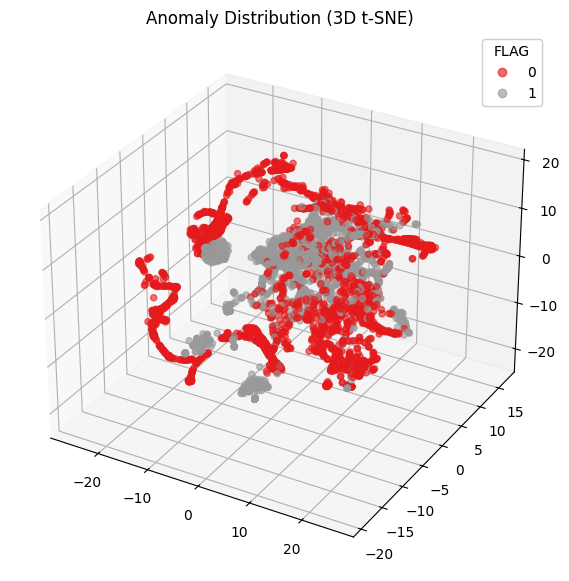

In [ ]:
df2 = df.copy()
df2 = df2.drop(columns=['Address', 'ERC20_most_sent_token_type', 'ERC20_most_rec_token_type'])
df2 = df2.fillna(df2.median())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df2.drop(columns=['FLAG']))
y = df2['FLAG']

# 차원축소 - 3차원
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# 그래프
tsne_df = pd.DataFrame(X_embedded, columns=['Dim1', 'Dim2', 'Dim3'])
tsne_df['FLAG'] = y.values

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(tsne_df['Dim1'], tsne_df['Dim2'], tsne_df['Dim3'], c=tsne_df['FLAG'], cmap='Set1', alpha=0.6)
ax.set_title("Anomaly Distribution (3D t-SNE)")
legend1 = ax.legend(*scatter.legend_elements(), title="FLAG")
ax.add_artist(legend1)

## XGBoost

In [ ]:
X = df.drop(columns=['FLAG', 'Address'])
y = df['FLAG']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

model = xgb.XGBClassifier(max_depth=4,
                          subsample=0.5,
                          objective='binary:logistic',
                          n_estimators=300,
                          learning_rate=0.2,
                          enable_categorical=True,
                          use_label_encoder=False,
                          eval_metric='logloss')

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))
print("f1score:", f1_score(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:43:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       499
           1       1.00      0.97      0.98       436

    accuracy                           0.99       935
   macro avg       0.99      0.98      0.98       935
weighted avg       0.99      0.99      0.99       935

0.9842345240940596


```
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       501
           1       1.00      0.97      0.98       436

    accuracy                           0.99       937
   macro avg       0.99      0.99      0.99       937
weighted avg       0.99      0.99      0.99       937

0.9853893131168855
```


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

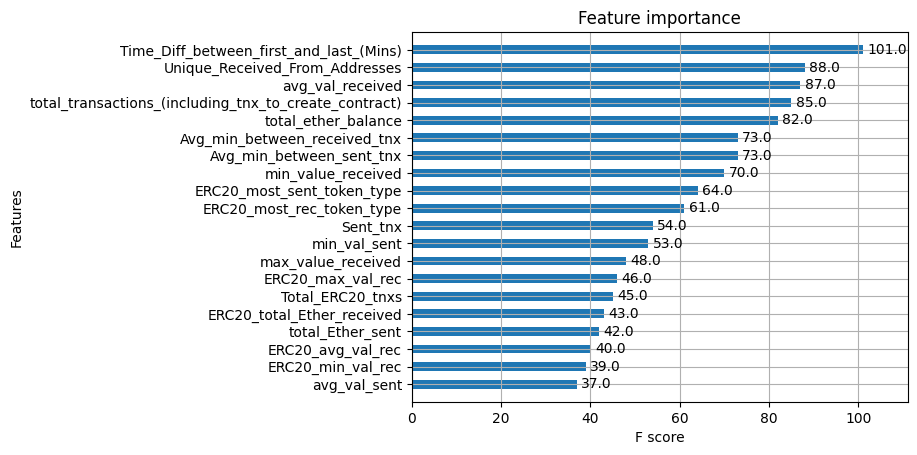

In [ ]:
# importance_type -> weight/gain/cover/total_gain/total_cover
xgb.plot_importance(model, importance_type='weight', max_num_features=20, height=0.5)

In [ ]:
# 하이퍼 파라미터
# param_grid = {
#     'n_estimators': [100, 150, 200],
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.1, 0.2, 0.3]
# }

# grid_search = GridSearchCV(
#     estimator=xgb_clf,
#     param_grid=param_grid,
#     scoring='roc_auc',
#     cv=10,
#     verbose=1,
#     n_jobs=-1
# )

## MLP

In [51]:
# 시드값 고정 (성능지표 재현 위해서)
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### 데이터 전처리

In [52]:
# 데이터 분할 + col_zero 컬럼 제외
X = df.drop(columns=['FLAG', 'Address', 'ERC20_most_sent_token_type', 'ERC20_most_rec_token_type']+col_zero)
y = df['FLAG']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test_df = X_test.copy()
y_test_df = y_test.copy()

# 결측치 처리 -> 결측치 중앙값으로 대체
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_test  = imputer.transform(X_test)

# 스케일링
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# torch.tensor로 변환
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

### 모델 훈련 및 예측

In [53]:
# class MLP(nn.Module):
#     def __init__(self, input_size=45, hidden_sizes=[], output_size=1):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_sizes[0])
#         self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
#         self.out = nn.Linear(hidden_sizes[1], output_size)
#         self.relu = nn.ReLU()
#         self.dropout = nn.Dropout(p=0.3)

#     def forward(self, x):

#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)

#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.dropout(x)

#         x = self.out(x)
#         return x

In [54]:
set_seed(42)

model = nn.Sequential(
    nn.Linear(X.shape[1], 200),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Dropout(0.4),

    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Dropout(0.4),

    # nn.Linear(80, 40),
    # nn.ReLU(),
    # nn.Dropout(0.5),

    nn.Linear(50, 1)
)

In [55]:
# 모델 초기화
#model = MLP(input_size=X.shape[1], hidden_sizes=[128, 64], output_size=1)

# 손실 함수와 최적화 기법
loss = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

model.train()
for step in range(600):
    pre = model(X_train)
    cost = loss(pre, y_train)
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()

### 모델 평가
사용한 지표: classification_report, roc_auc_score

#### **classification_report**
- precision: positive로 예측한 것 중에서 실제로 positive한 것의 비율
- recall: 실제로 positive한 것 중에서 positive로 예측한 것의 비율
- f1-score: precision과 recall의 조화평균
- accuracy: 정확히 예측한 비율
- support: 각 클래스별 샘플 개수

#### **roc_auc_score**
- 머신러닝 분류모델의 성능을 평가하는 지표
- 이진 분류에 주로 사용
- AUC: ROC 곡선 아래의 면적을 구한 값
- ROC 곡선: TPR과 FPR의 관계를 나타내는 그래프

In [56]:
model.eval()

with torch.no_grad():
    y_pred = model(X_test)
    y_pred_prob = torch.sigmoid(y_pred).numpy()
    y_pred_class = (y_pred_prob >= 0.5).astype(int).squeeze()

print(classification_report(y_test.numpy().astype(int), y_pred_class))
print("f1score:", f1_score(y_test.numpy().astype(int), y_pred_class))
print("AUC:", roc_auc_score(y_test.numpy(), y_pred_prob))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       499
           1       0.97      0.98      0.98       436

    accuracy                           0.98       935
   macro avg       0.98      0.98      0.98       935
weighted avg       0.98      0.98      0.98       935

f1score: 0.976054732041049
AUC: 0.9948474931514404


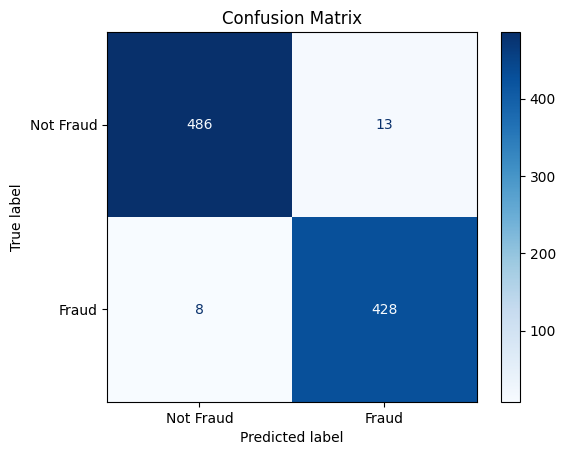

In [59]:
# 혼동 행렬
cm = confusion_matrix(y_test.numpy().astype(int), y_pred_class)

# 시각화
cm_g = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
cm_g.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

- 사기를 사기가 아닌 것으로 잘못 탐지 => 13
- 사기가 아닌 것을 사기로 잘못 탐지 => 8

In [60]:
# 오분류된 인덱스 추출
wrong_mask = (y_test.numpy().astype(int).squeeze() != y_pred_class)
wrong_index = X_test_df.index[wrong_mask]

# 오분류된 계정 추출
miss_accounts = df.loc[wrong_index].copy()
miss_accounts["actual"] = y_test_df.loc[wrong_index]
miss_accounts["predicted"] = y_pred_class[wrong_mask]
miss_accounts[["Address", "actual", "predicted"]]

,Address,actual,predicted
2716,0x6d57fe045dcced8b289db59f66cd4354b6483d63,0,1
2116,0xf8e676094628776690dbf83fa31f08aa14fd3fb8,1,0
3430,0x00d4a560da94790c8d508a7edda6465d7a3e9a49,0,1
204,0x169b6c7ed548e45ba9d87b2d32ff27e2d00051ef,1,0
3845,0x5814ef71a47ee8b3c7c3dc6322087cfe681e4413,0,1
2884,0x8f30d40765de7eeeb750f44e0bf0487f8e1e7e78,0,1
335,0x24aa18952e80707dad3ab4c9c97e787f2af337ca,1,0
2775,0x7932e1ed8586fff9eb41944a9e4af52a1ea3ce3e,0,1
237,0x19fb7020381fe9197bf841d5034d5467fe5a3c93,1,0
1291,0x94d50168d9bc80cc39affbcba8232acd89f117a3,1,0


### 모델 분류 결과 분석
**오분류된 사기계정**
- 0xf8e676094628776690dbf83fa31f08aa14fd3fb8 -> Phishing scam
- 0x169b6c7ed548e45ba9d87b2d32ff27e2d00051ef -> Phishing scam
- 0x24aa18952e80707dad3ab4c9c97e787f2af337ca -> Phishing scam
- 0x19fb7020381fe9197bf841d5034d5467fe5a3c93 -> Phishing scam
- 0x94d50168d9bc80cc39affbcba8232acd89f117a3 -> Phishing scam
- 0x65f6c0e45758526982fa5f63ac877384ea5a91bd -> Phishing scam
- 0xb9b848702a47ae78a70d18c45e552ab1637b5908 -> Phishing scam
- 0x8e8f4161c9c3d2d8857230a048df1fc6f4326948 -> Phishing scam


**FLAG와의 상관관계가 높은 상위 5개 컬럼**
1. Time_Diff_between_first_and_last_(Mins)
2. total_transactions_(including_tnx_to_create_contract)
3. Received_Tnx
4. Avg_min_between_received_tnx
5. Sent_tnx

In [87]:
miss_fraud = miss_accounts[miss_accounts['actual']==1] # 잘못 분류된 사기 데이터
full_fraud = df[df['FLAG']==1]                         # 전체 사기 데이터

<Axes: xlabel='Time_Diff_between_first_and_last_(Mins)', ylabel='total_transactions_(including_tnx_to_create_contract)'>

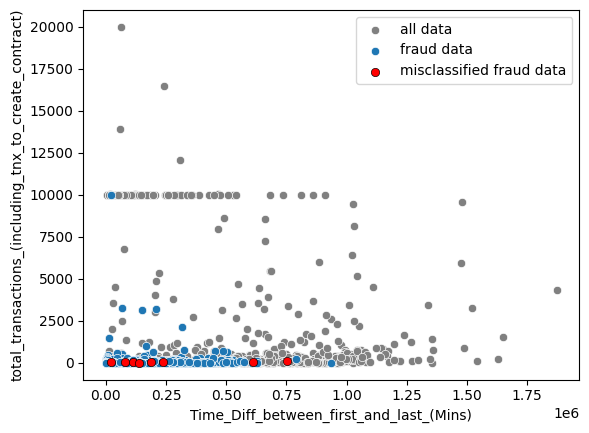

In [114]:
sns.scatterplot(df, x='Time_Diff_between_first_and_last_(Mins)', y='total_transactions_(including_tnx_to_create_contract)', color='grey', label='all data')
sns.scatterplot(full_fraud, x='Time_Diff_between_first_and_last_(Mins)', y='total_transactions_(including_tnx_to_create_contract)', label='fraud data')
sns.scatterplot(miss_fraud, x='Time_Diff_between_first_and_last_(Mins)', y='total_transactions_(including_tnx_to_create_contract)', color='red', edgecolor='black', label='misclassified fraud data')

<Axes: xlabel='Received_Tnx', ylabel='Sent_tnx'>

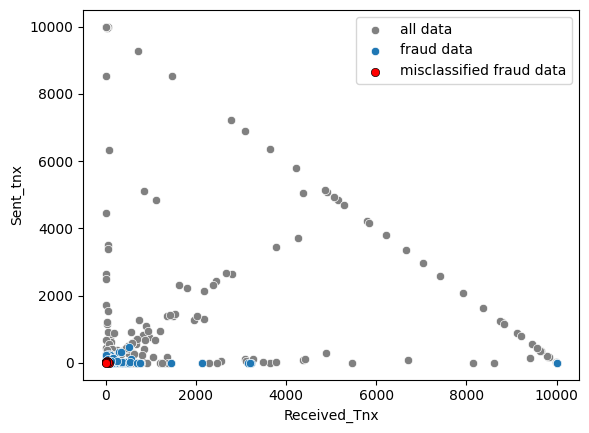

In [115]:
sns.scatterplot(df, x='Received_Tnx', y='Sent_tnx', color='grey', label='all data')
sns.scatterplot(full_fraud, x='Received_Tnx', y='Sent_tnx', label='fraud data')
sns.scatterplot(miss_fraud, x='Received_Tnx', y='Sent_tnx', color='red', edgecolor='black', label='misclassified fraud data')

<Axes: xlabel='Time_Diff_between_first_and_last_(Mins)', ylabel='Avg_min_between_received_tnx'>

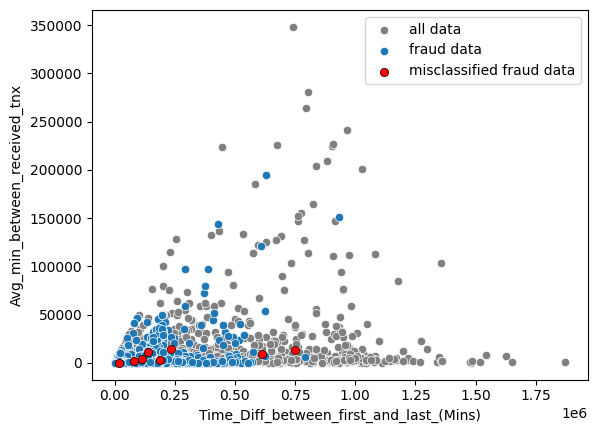

In [116]:
sns.scatterplot(df, x='Time_Diff_between_first_and_last_(Mins)', y='Avg_min_between_received_tnx', color='grey', label='all data')
sns.scatterplot(full_fraud, x='Time_Diff_between_first_and_last_(Mins)', y='Avg_min_between_received_tnx', label='fraud data')
sns.scatterplot(miss_fraud, x='Time_Diff_between_first_and_last_(Mins)', y='Avg_min_between_received_tnx', color='red', edgecolor='black', label='misclassified fraud data')

## MLP 튜닝

#### 그리드 서치 느낌

In [ ]:
hidden_layer_sizes = [
    [240, 128, 64],
    [150, 64, 32],
    [200, 100, 50]
]
dropouts = [0.3, 0.4, 0.5]
learning_rates = [0.005, 0.01, 0.05]
epochs_list = [400, 500, 600]

In [ ]:
set_seed(42)

results = []
best_auc = 0
best_param = None

for layer_sizes in hidden_layer_sizes:
    for dropout_rate in dropouts:
        for lr in learning_rates:
            for epochs in epochs_list:
                set_seed(42)

                # 모델 정의
                layers = []
                input_dim = X_train.shape[1]
                for size in layer_sizes:
                    layers.append(nn.Linear(input_dim, size))
                    layers.append(nn.ReLU())
                    layers.append(nn.Dropout(dropout_rate))
                    input_dim = size
                layers.append(nn.Linear(input_dim, 1))
                model = nn.Sequential(*layers)

                # 학습 준비
                loss = nn.BCEWithLogitsLoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # 학습
                model.train()
                for step in range(epochs):
                    pre = model(X_train)
                    cost = loss(pre, y_train)
                    optimizer.zero_grad()
                    cost.backward()
                    optimizer.step()

                # 평가
                model.eval()
                with torch.no_grad():
                    y_pred = model(X_test)
                    y_pred_prob = torch.sigmoid(y_pred).numpy()
                    y_pred_class = (y_pred_prob >= 0.5).astype(int).squeeze()

                    auc = roc_auc_score(y_test.numpy(), y_pred_prob)
                    f1score = f1_score(y_test.numpy().astype(int), y_pred_class)

                # 결과 저장
                results.append({
                    'AUC': auc,
                    'F1Score': f1score,
                    'layers': layer_sizes,
                    'dropout': dropout_rate,
                    'lr': lr,
                    'epochs': epochs
                })

                if auc > best_auc:
                    best_auc = auc
                    best_param = {
                        'layers': layer_sizes,
                        'dropout': dropout_rate,
                        'lr': lr,
                        'epochs': epochs
                    }

                print(f"[AUC: {auc:.4f}] {layer_sizes}, dropout={dropout_rate}, lr={lr}, epochs={epochs}")

results_df = pd.DataFrame(results)
print("\nBest AUC:", best_auc)
print("Best param:", best_param)


[AUC: 0.9920] [240, 128, 64], dropout=0.3, lr=0.005, epochs=400
[AUC: 0.9916] [240, 128, 64], dropout=0.3, lr=0.005, epochs=500
[AUC: 0.9916] [240, 128, 64], dropout=0.3, lr=0.005, epochs=600
[AUC: 0.9921] [240, 128, 64], dropout=0.3, lr=0.01, epochs=400
[AUC: 0.9917] [240, 128, 64], dropout=0.3, lr=0.01, epochs=500
[AUC: 0.9914] [240, 128, 64], dropout=0.3, lr=0.01, epochs=600
[AUC: 0.9909] [240, 128, 64], dropout=0.3, lr=0.05, epochs=400
[AUC: 0.9901] [240, 128, 64], dropout=0.3, lr=0.05, epochs=500
[AUC: 0.9892] [240, 128, 64], dropout=0.3, lr=0.05, epochs=600
[AUC: 0.9925] [240, 128, 64], dropout=0.4, lr=0.005, epochs=400
[AUC: 0.9924] [240, 128, 64], dropout=0.4, lr=0.005, epochs=500
[AUC: 0.9923] [240, 128, 64], dropout=0.4, lr=0.005, epochs=600
[AUC: 0.9920] [240, 128, 64], dropout=0.4, lr=0.01, epochs=400
[AUC: 0.9926] [240, 128, 64], dropout=0.4, lr=0.01, epochs=500
[AUC: 0.9916] [240, 128, 64], dropout=0.4, lr=0.01, epochs=600
[AUC: 0.9819] [240, 128, 64], dropout=0.4, lr=0.0

Best AUC: 0.9948474931514404

Best param: {'layers': [200, 100, 50], 'dropout': 0.4, 'lr': 0.005, 'epochs': 600}

In [ ]:
results_df_copy = results_df.copy()

In [ ]:
results_df

,AUC,F1Score,layers,dropout,lr,epochs
0,0.992044,0.967963,"[240, 128, 64]",0.3,0.005,400
1,0.991609,0.965675,"[240, 128, 64]",0.3,0.005,500
2,0.991637,0.964652,"[240, 128, 64]",0.3,0.005,600
3,0.992129,0.965675,"[240, 128, 64]",0.3,0.010,400
4,0.991708,0.967963,"[240, 128, 64]",0.3,0.010,500
...,...,...,...,...,...,...
76,0.993480,0.965035,"[200, 100, 50]",0.5,0.010,500
77,0.993834,0.968786,"[200, 100, 50]",0.5,0.010,600
78,0.989787,0.947126,"[200, 100, 50]",0.5,0.050,400
79,0.987372,0.937931,"[200, 100, 50]",0.5,0.050,500


In [ ]:
params = ['dropout', 'lr', 'epochs']
metrics = ['AUC', 'F1Score']

results_df['layers'] = results_df['layers'].apply(str)
filtered_df = results_df[results_df['layers'] == '[200, 100, 50]']

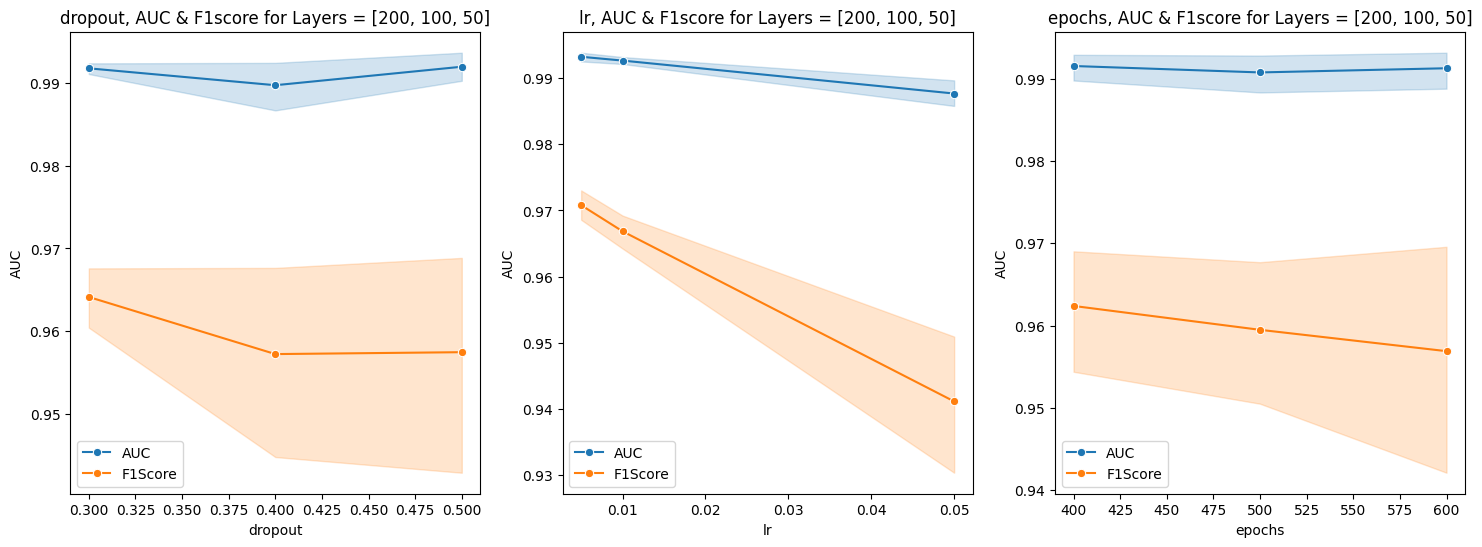

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, param in enumerate(params):
  col=i%3
  sns.lineplot(data=filtered_df, x=param, y='AUC', marker='o', label='AUC', ax=axes[col])
  sns.lineplot(data=filtered_df, x=param, y='F1Score', marker='o', label='F1Score', ax=axes[col])
  axes[col].set_title(f'{param}, AUC & F1score for Layers = [200, 100, 50]')

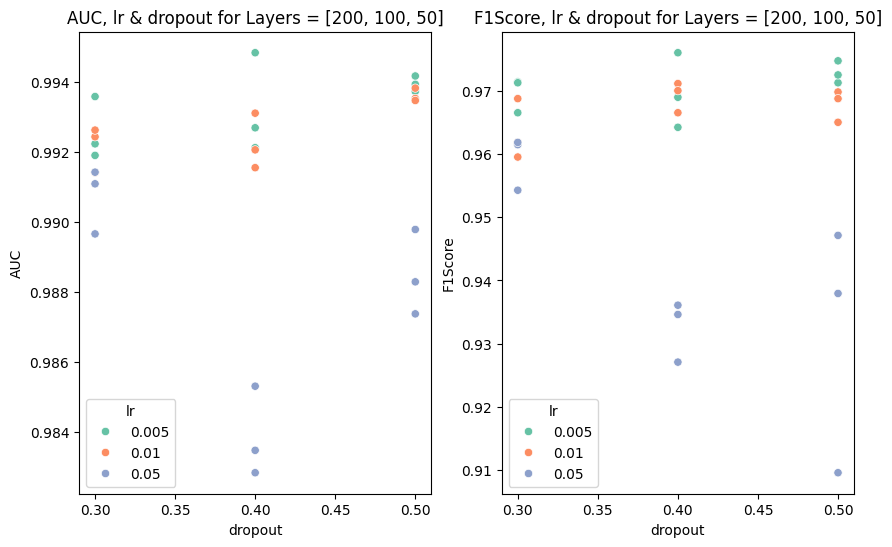

In [ ]:
# lr & dropout -> AUC, F1score
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

for i, metric in enumerate(metrics):
  col=i%2
  sns.scatterplot(data=filtered_df, x='dropout', y=metric, hue='lr', marker='o', palette='Set2', ax=axes[col])
  axes[col].set_title(f'{metric}, lr & dropout for Layers = [200, 100, 50]')

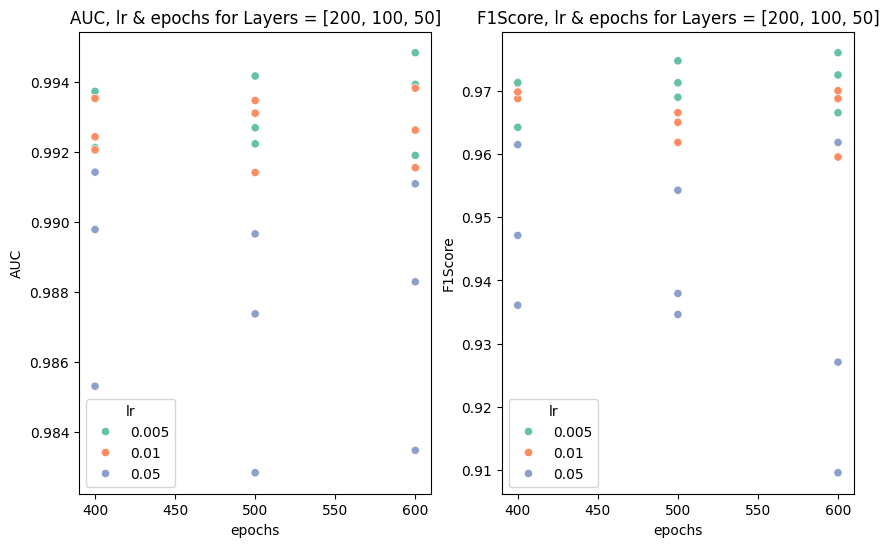

In [ ]:
# lr & epochs -> AUC, F1score
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

for i, metric in enumerate(metrics):
  col=i%2
  sns.scatterplot(data=filtered_df, x='epochs', y=metric, hue='lr', marker='o', palette='Set2', ax=axes[col])
  axes[col].set_title(f'{metric}, lr & epochs for Layers = [200, 100, 50]')

#### 베이지안 최적화

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 8.0 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
set_seed(42)

def objective(trial):

    # 하이퍼파라미터 탐색 범위
    num_layers = 4
    hidden_sizes = [trial.suggest_int(f"hidden_size_{i}", 16, 256, step=16) for i in range(num_layers)]
    dropouts = [trial.suggest_float(f"dropout_{i}", 0.2, 0.5) for i in range(num_layers)]
    lr = trial.suggest_float("lr", 1e-2, 1e-1, log=True)
    epochs = trial.suggest_int("epochs", 300, 600)

    # 모델
    set_seed(42)

    layers = []
    input_size = X_train.shape[1]
    for i in range(num_layers):
        layers.append(nn.Linear(input_size if i == 0 else hidden_sizes[i-1], hidden_sizes[i]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropouts[i]))
    layers.append(nn.Linear(hidden_sizes[-1], 1))
    model = nn.Sequential(*layers)

    # 손실함수 및 옵티마이저
    loss = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 모델 학습
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        pre = model(X_train)
        cost = loss(pre, y_train)
        cost.backward()
        optimizer.step()

    # 모델 평가 - AUC
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_prob = torch.sigmoid(y_pred).numpy()
        auc = roc_auc_score(y_test.numpy(), y_pred_prob)

    return auc

# 최적화
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

study.best_params

[I 2025-05-14 15:06:03,319] A new study created in memory with name: no-name-cc08624b-812d-4488-b691-04e50d6675ac
[I 2025-05-14 15:06:48,168] Trial 0 finished with value: 0.5 and parameters: {'hidden_size_0': 224, 'hidden_size_1': 16, 'hidden_size_2': 192, 'hidden_size_3': 144, 'dropout_0': 0.34743804754208174, 'dropout_1': 0.3979358501110387, 'dropout_2': 0.4079570103440686, 'dropout_3': 0.26338069099708805, 'lr': 0.0844963357528188, 'epochs': 533}. Best is trial 0 with value: 0.5.
[I 2025-05-14 15:07:27,773] Trial 1 finished with value: 0.9333437517236307 and parameters: {'hidden_size_0': 144, 'hidden_size_1': 144, 'hidden_size_2': 144, 'hidden_size_3': 48, 'dropout_0': 0.42154103187766917, 'dropout_1': 0.3731752382519157, 'dropout_2': 0.4520023318030401, 'dropout_3': 0.3299629908249607, 'lr': 0.09807654543257288, 'epochs': 574}. Best is trial 1 with value: 0.9333437517236307.
[I 2025-05-14 15:08:02,023] Trial 2 finished with value: 0.9924688827195676 and parameters: {'hidden_size_0'

{'hidden_size_0': 128,
 'hidden_size_1': 256,
 'hidden_size_2': 48,
 'hidden_size_3': 192,
 'dropout_0': 0.4087832597390312,
 'dropout_1': 0.24973939422642855,
 'dropout_2': 0.3732635005454729,
 'dropout_3': 0.4605721499335525,
 'lr': 0.028053459529524948,
 'epochs': 446}